# KoçFinans Case Study


**Problem Statement:**


Develop and assess a machine learning model to predict the loan status of clients. Provide a comprehensive classification report summarizing the model’s performance metrics.

# 1. Data Preprocessing

In [55]:
!pip install -q optuna
!pip install -q shap
!pip install -q scikit-optimize

In [56]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import xgboost as xgb
import lightgbm as lgb
import optuna
import shap

# Import specific functions from libraries
from scipy.stats import ttest_ind
from lightgbm import LGBMClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay, f1_score,
    roc_auc_score, precision_recall_curve, auc, make_scorer, precision_score
)
from sklearn.impute import KNNImputer
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from skopt import BayesSearchCV
from skopt.space import Integer, Real, Categorical

# Set display options for pandas to enhance readability
pd.options.display.float_format = '{:.3f}'.format
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Suppress warnings for a cleaner output
warnings.filterwarnings('ignore')

# Print versions of the imported libraries
library_versions = {
    "numpy": np.__version__,
    "pandas": pd.__version__,
    "seaborn": sns.__version__,
    "lightgbm": lgb.__version__,
    "xgboost": xgb.__version__,
    "optuna": optuna.__version__,
    "shap": shap.__version__
}

# Print all library versions
for lib, version in library_versions.items():
    print(f"{lib}: {version}")


numpy: 1.25.2
pandas: 2.0.3
seaborn: 0.13.1
lightgbm: 4.1.0
xgboost: 2.0.3
optuna: 3.6.1
shap: 0.45.1


Load Data

In [57]:
data=pd.read_csv("loan_approval_dataset.csv")

In [58]:
data.head(3)

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected


In [59]:
# Create a copy of the original data frame to preserve the integrity of the dataset
loan_data=data.copy()

Data Info

There is a dataset consisting of
4269 rows and 13 columns.

In [60]:
loan_data.shape

(4269, 13)

In [61]:
loan_data.columns

Index(['loan_id', ' no_of_dependents', ' education', ' self_employed',
       ' income_annum', ' loan_amount', ' loan_term', ' cibil_score',
       ' residential_assets_value', ' commercial_assets_value',
       ' luxury_assets_value', ' bank_asset_value', ' loan_status'],
      dtype='object')

  **loan_id:** A unique identifier for each loan application.
  
  **no_of_dependents:** The number of dependents the customer has.
  
  **education:** The educational background of the customer (e.g., bachelor’s, master’s).
  
  **self_employed:** Indicates whether the customer is self-employed.
  
  **income_annum:** The annual income of the customer
  
  **loan_amount:** The amount of the loan requested.
  
  **loan_term:** The loan term (in months).
  
  **cibil_score:** The credit score of the customer
  
  **residential_assets_value:** The total value of the customer’s residential assets
  
  **commercial_assets_value:** The total value of the customer’s commercial assets.
  
  **luxury_assets_value:** The total value of the customer’s luxury assets (e.g., yacht, luxury car).
  
  **bank_asset_value:** The total value of the customer’s bank assets.
  
  **loan_status:** The status of the loan application (e.g., approved/rejected).

In [62]:
loan_data.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   loan_id                    4269 non-null   int64 
 1    no_of_dependents          4269 non-null   int64 
 2    education                 4269 non-null   object
 3    self_employed             4269 non-null   object
 4    income_annum              4269 non-null   int64 
 5    loan_amount               4269 non-null   int64 
 6    loan_term                 4269 non-null   int64 
 7    cibil_score               4269 non-null   int64 
 8    residential_assets_value  4269 non-null   int64 
 9    commercial_assets_value   4269 non-null   int64 
 10   luxury_assets_value       4269 non-null   int64 
 11   bank_asset_value          4269 non-null   int64 
 12   loan_status               4269 non-null   object
dtypes: int64(10), object(3)
memory usage: 433.7+ KB


In [63]:
# Strip leading and trailing spaces from column names
loan_data.columns = loan_data.columns.str.strip()

In [64]:
# representing categorical variables
cats=loan_data.select_dtypes("object").columns.drop(['loan_status']).tolist()
cats

['education', 'self_employed']

In [65]:
# representing numerical variables
nums=loan_data.select_dtypes(exclude=["object"]).columns.drop(['loan_id']).tolist()
nums

['no_of_dependents',
 'income_annum',
 'loan_amount',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value',
 'luxury_assets_value',
 'bank_asset_value']

In [66]:
pd.set_option("display.max_columns",None)
loan_data[nums].describe().T

,count,mean,std,min,25%,50%,75%,max
no_of_dependents,4269.000,2.499,1.696,0.000,1.000,3.000,4.000,5.000
income_annum,4269.000,5059123.917,2806839.832,200000.000,2700000.000,5100000.000,7500000.000,9900000.000
loan_amount,4269.000,15133450.457,9043362.985,300000.000,7700000.000,14500000.000,21500000.000,39500000.000
loan_term,4269.000,10.900,5.709,2.000,6.000,10.000,16.000,20.000
cibil_score,4269.000,599.936,172.430,300.000,453.000,600.000,748.000,900.000
residential_assets_value,4269.000,7472616.538,6503636.588,-100000.000,2200000.000,5600000.000,11300000.000,29100000.000
commercial_assets_value,4269.000,4973155.306,4388966.090,0.000,1300000.000,3700000.000,7600000.000,19400000.000
luxury_assets_value,4269.000,15126305.926,9103753.665,300000.000,7500000.000,14600000.000,21700000.000,39200000.000
bank_asset_value,4269.000,4976692.434,3250185.306,0.000,2300000.000,4600000.000,7100000.000,14700000.000


**Summary statistics for numerical variables relevant to loan prediction:**

**no_of_dependents:**
Mean: 2.5, Std: 1.7, Range: 0-5.
Moderate variability in number of dependents.

**income_annum:**
Mean: 5,059,124, Std: 2,806,840, Range: 200,000-9,900,000.
High income variability, significant predictor for loan repayment ability.

**Loan_amount:**
Mean: 15,133,450, Std: 9,043,363, Range: 300,000-39,500,000.
Large variation in loan amounts, critical for risk assessment.

**loan_term:**
Mean: 11 months, Std: 5.7 months, Range: 2-20 months.
Variation in loan duration affects repayment schedules.

**cibil_score:**
Mean: 600, Std: 172, Range: 300-900.
Key indicator of creditworthiness, essential for predicting loan status.

**residential_assets_value:**
Mean: 7,472,617, Std: 6,503,637, Range: -100,000-29,100,000.
Significant skew, indicates customer's asset backing.

**commercial_assets_value:**
Mean: 4,973,155, Std: 4,388,966, Range: 0-19,400,000.
High variability, important for assessing financial stability.

**luxury_assets_value:**
Mean: 15,126,306, Std: 9,103,754, Range: 300,000-39,200,000.
Reflects financial standing, impacts loan risk evaluation.

**bank_asset_value:**
Mean: 4,976,692, Std: 3,250,185, Range: 0-14,700,000.
Indicates liquidity, crucial for determining repayment capacity.


**Check Null Value**

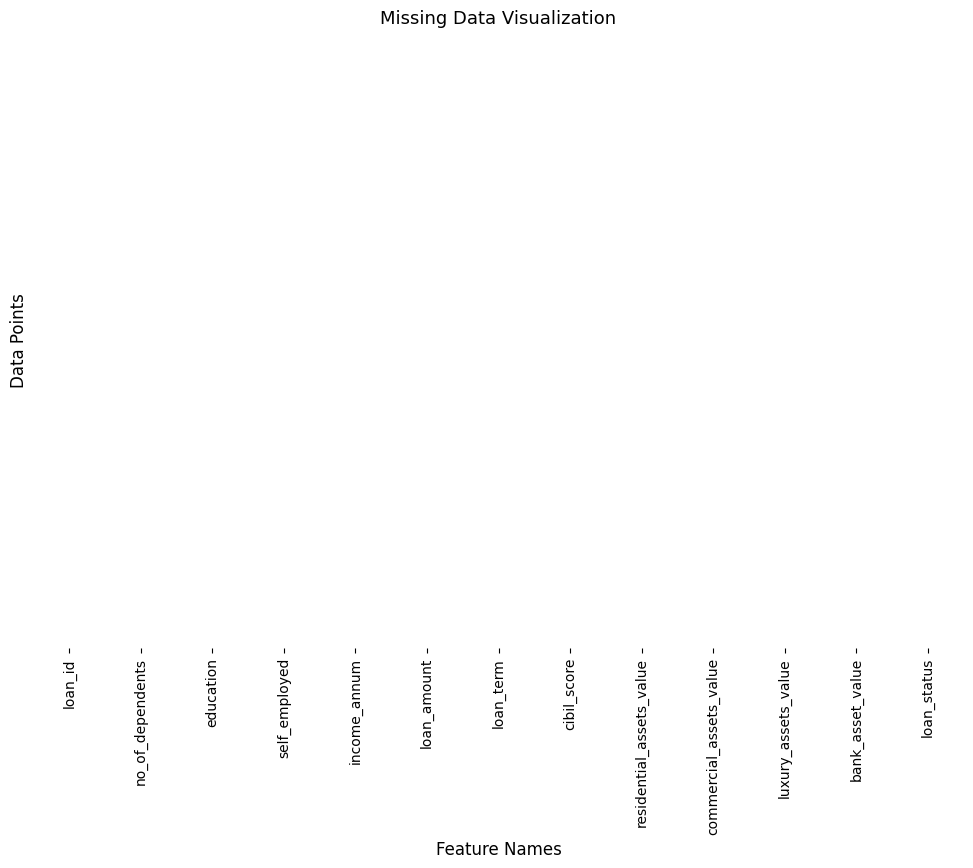

In [67]:
plt.figure(figsize=(12, 8))
sns.heatmap(loan_data.isnull(), cmap='binary', cbar=False, yticklabels=False)
plt.title('Missing Data Visualization', fontsize=13)
plt.xlabel('Feature Names', fontsize=12)
plt.ylabel('Data Points', fontsize=12)
plt.show()

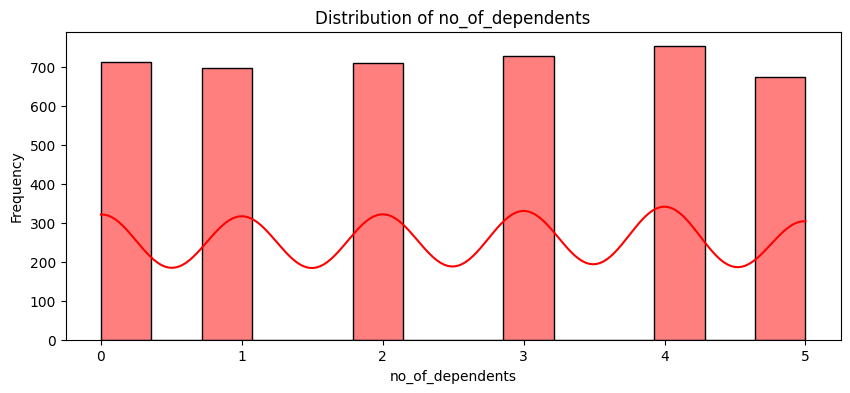

Skewness of no_of_dependents: -0.01797054296784964
Kurtosis of no_of_dependents: -1.256992233744976


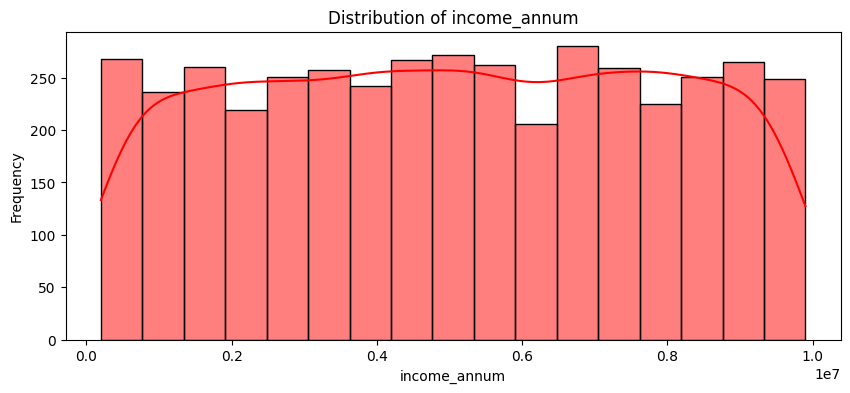

Skewness of income_annum: -0.012814425096650109
Kurtosis of income_annum: -1.182728975874057


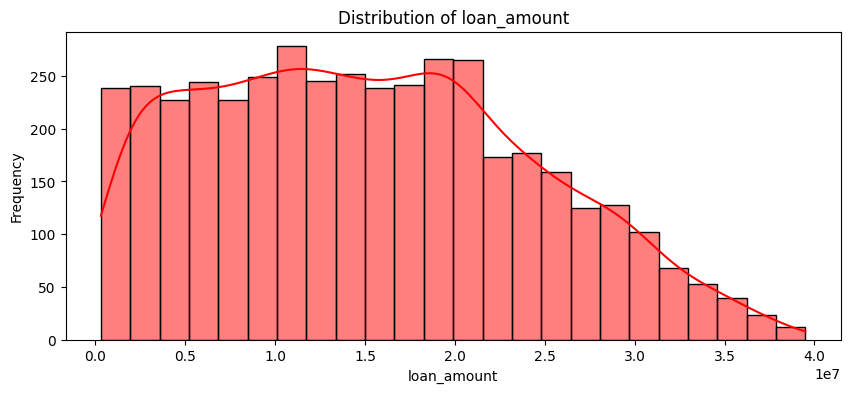

Skewness of loan_amount: 0.30872388482299223
Kurtosis of loan_amount: -0.7436797209184856


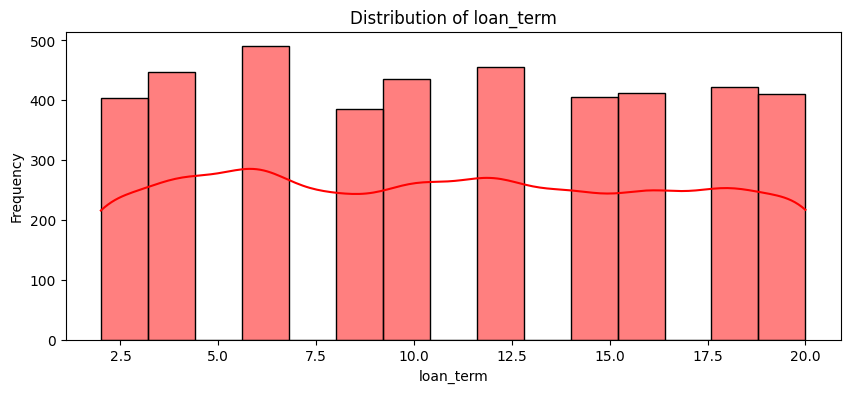

Skewness of loan_term: 0.036358907356478495
Kurtosis of loan_term: -1.2208527369898254


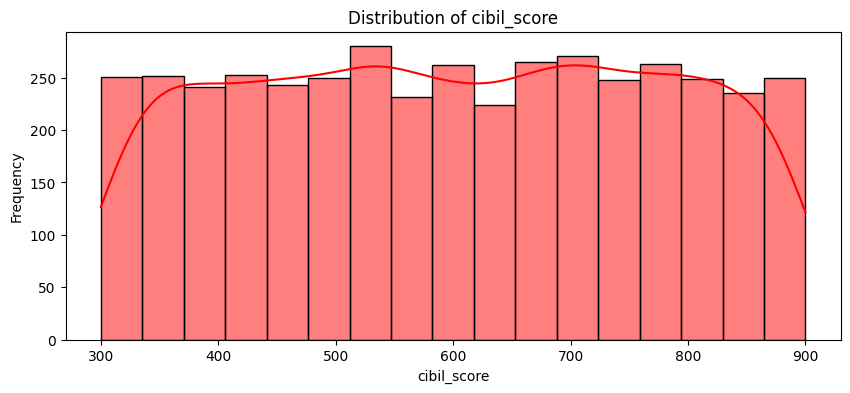

Skewness of cibil_score: -0.009039277330065707
Kurtosis of cibil_score: -1.1856695832238278


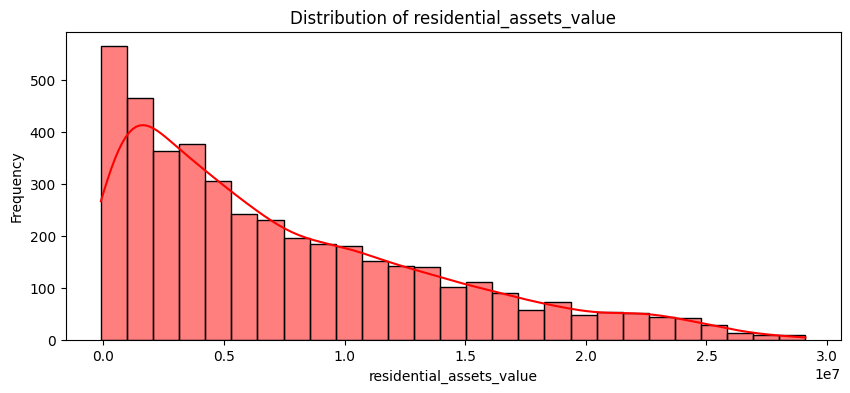

Skewness of residential_assets_value: 0.9784505965115631
Kurtosis of residential_assets_value: 0.18473799432821192


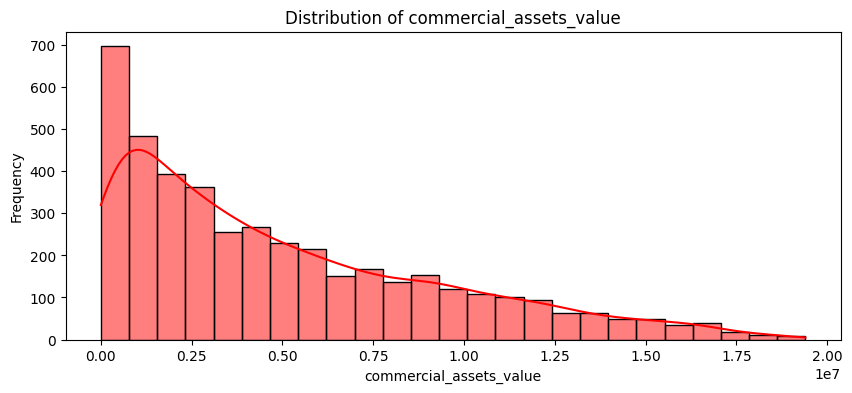

Skewness of commercial_assets_value: 0.9577908874986114
Kurtosis of commercial_assets_value: 0.1008126034954202


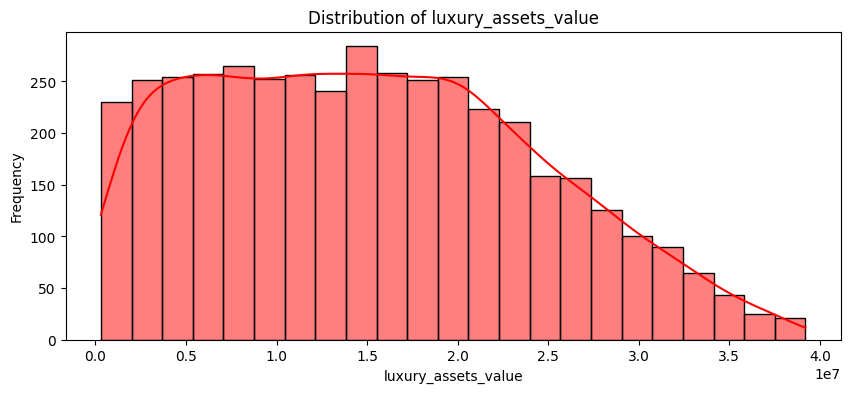

Skewness of luxury_assets_value: 0.3222075028955774
Kurtosis of luxury_assets_value: -0.7380561342202601


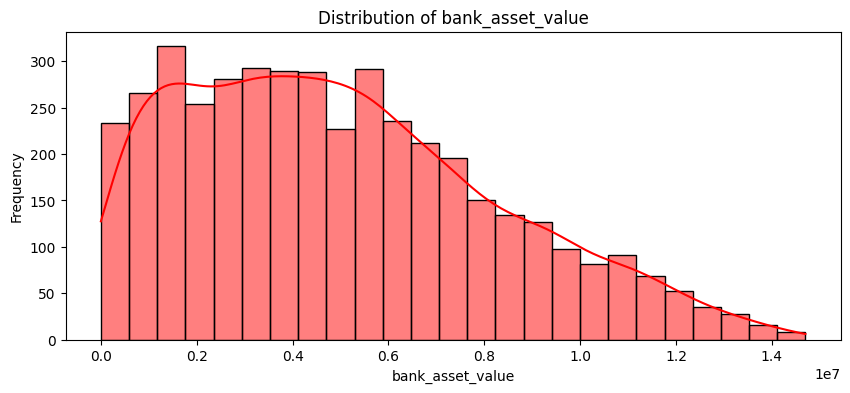

Skewness of bank_asset_value: 0.5607250089736816
Kurtosis of bank_asset_value: -0.39727743339035904


In [68]:

for column in loan_data[nums].columns:
    plt.figure(figsize=(10, 4))
    sns.histplot(loan_data[nums][column], kde=True, color='red')
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')
    plt.show()

 #calculate skewness and kurtosis values to analyze distrubution
    print(f'Skewness of {column}:', loan_data[nums][column].skew())
    print(f'Kurtosis of {column}:', loan_data[nums][column].kurt())



**no_of_dependents:**
Almost symmetric distribution, low kurtosis indicates fewer outliers.

**income_annum:**
Nearly symmetric distribution, low kurtosis suggests a lack of extreme values.

**loan_amount:**
Slight positive skew, indicating some spread in loan amounts.

**loan_term:**
Almost symmetric distribution, low kurtosis suggests few outliers in loan duration.

**cibil_score:**
Nearly symmetric distribution, low kurtosis indicates a lack of extreme credit scores.

**residential_assets_value:**
Positive skew indicates more high-value assets.

**commercial_assets_value:**
Positive skew with a slight leptokurtic nature, showing more high-value commercial assets.

**luxury_assets_value:**
Slight positive skew, indicating a spread in luxury assets.

**bank_asset_value:**
Positive skew, indicating a spread in bank asset values.

These skewness and kurtosis values provide insights into the distribution of each variable, which is crucial for feature engineering and model selection in predicting loan status.

Check outlier values

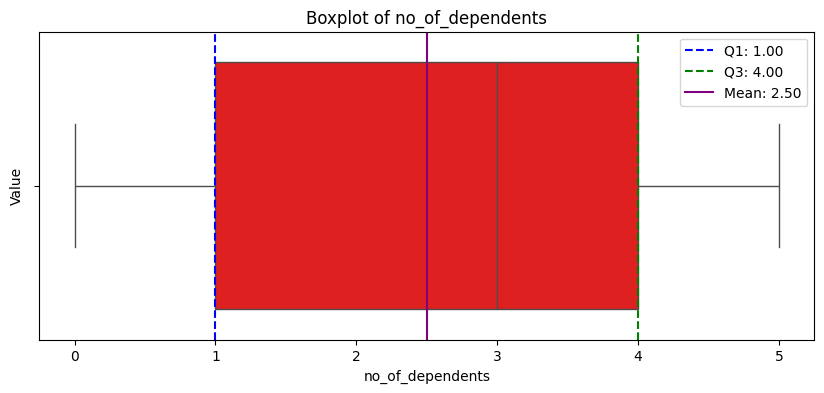

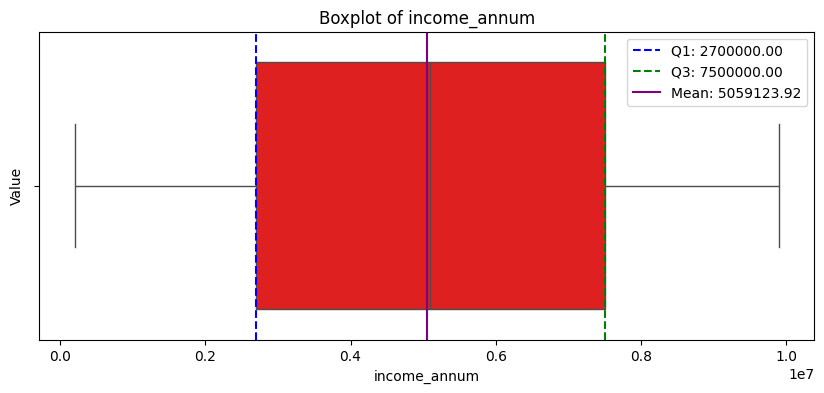

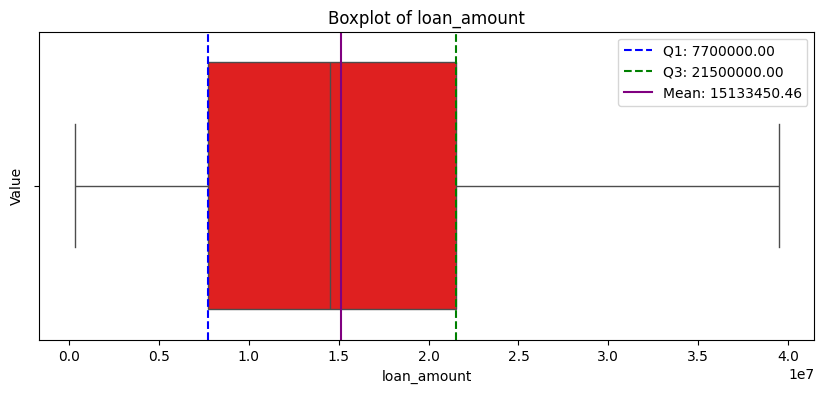

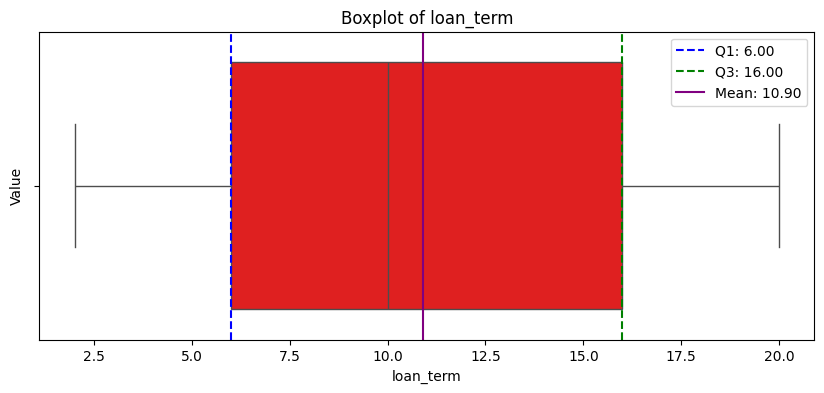

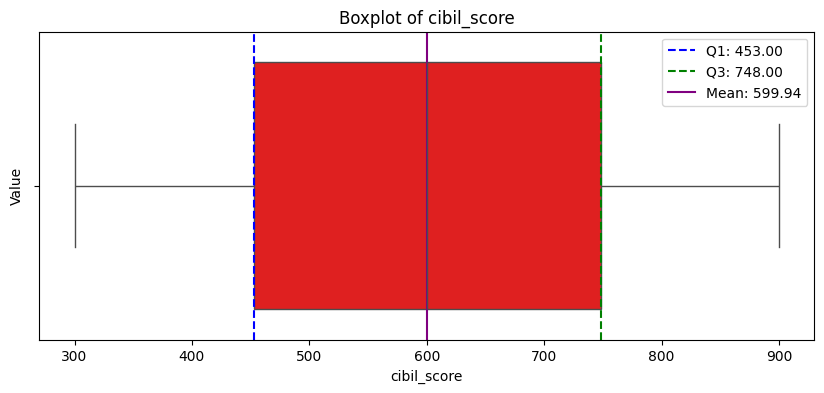

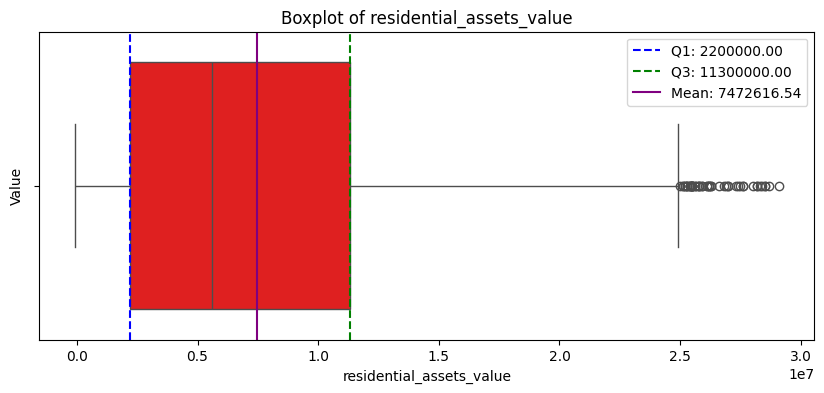

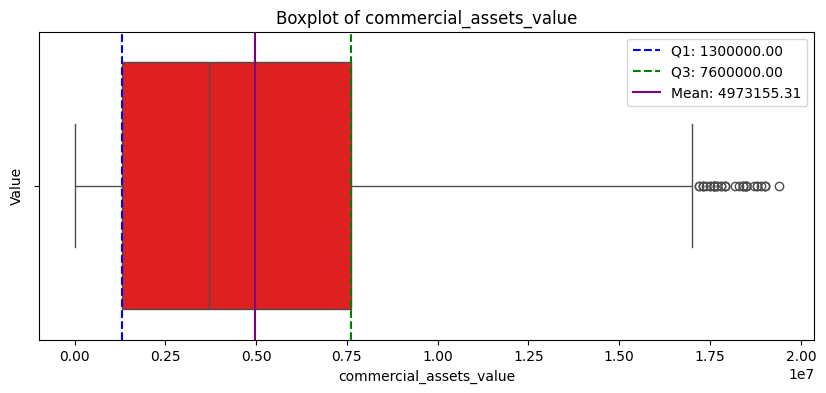

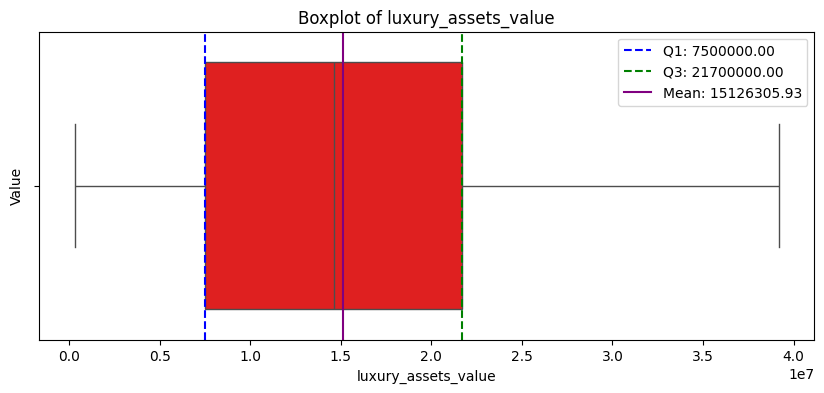

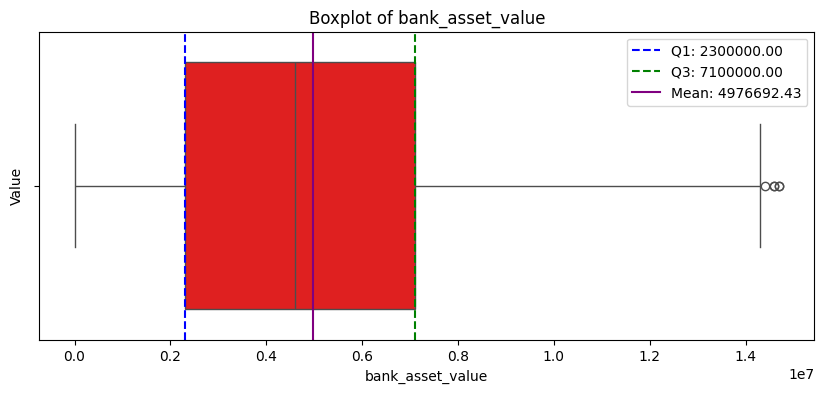

In [69]:

num_cols_box = loan_data[nums].columns

for column in num_cols_box:
    plt.figure(figsize=(10, 4))
    sns.boxplot(x=loan_data[column], color='red')
    plt.title(f'Boxplot of {column}')


    Q1 = loan_data[column].quantile(0.25)
    Q3 = loan_data[column].quantile(0.75)
    mean = loan_data[column].mean()


    plt.axvline(x=Q1, color='blue', linestyle='--', label=f'Q1: {Q1:.2f}')
    plt.axvline(x=Q3, color='green', linestyle='--', label=f'Q3: {Q3:.2f}')
    plt.axvline(x=mean, color='purple', linestyle='-', label=f'Mean: {mean:.2f}')

    plt.xlabel(column)
    plt.ylabel('Value')
    plt.legend()
    plt.show()

In [70]:
lower_bound = loan_data[column].quantile(0.01)
upper_bound = loan_data[column].quantile(0.99)
loan_data[column] = np.where(loan_data[column] < lower_bound, lower_bound, loan_data[column])
loan_data[column] = np.where(loan_data[column] > upper_bound, upper_bound, loan_data[column])

This approach caps the extreme values at the 99th and 1st percentile, reducing the impact of outliers. This method ensures that the model is not overly influenced by extreme values, leading to more robust and generalizable predictions.

# 2.Data Visualization & Insights

In [71]:
loan_data.loan_status.value_counts()

loan_status
 Approved    2656
 Rejected    1613
Name: count, dtype: int64

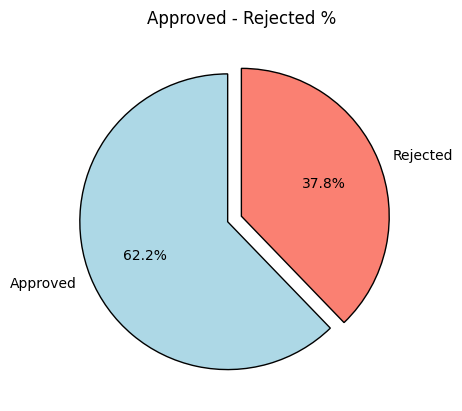

In [72]:
loan_counts = loan_data['loan_status'].value_counts()
loan_percentages = [count / loan_counts.sum() * 100 for count in loan_counts]

labels = ['Approved', 'Rejected']
colors = ['lightblue', 'salmon']
plt.pie(loan_percentages, labels=labels, autopct='%1.1f%%', startangle=90, explode=(0.1, 0), colors=colors,
        wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
plt.title('Approved - Rejected %')
plt.show()

In [73]:
loan_data.loan_status.value_counts()

loan_status
 Approved    2656
 Rejected    1613
Name: count, dtype: int64

In [74]:
loan_data.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000.000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000.000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000.000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000.000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000.000,Rejected


In [75]:
loan_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4269 entries, 0 to 4268
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   loan_id                   4269 non-null   int64  
 1   no_of_dependents          4269 non-null   int64  
 2   education                 4269 non-null   object 
 3   self_employed             4269 non-null   object 
 4   income_annum              4269 non-null   int64  
 5   loan_amount               4269 non-null   int64  
 6   loan_term                 4269 non-null   int64  
 7   cibil_score               4269 non-null   int64  
 8   residential_assets_value  4269 non-null   int64  
 9   commercial_assets_value   4269 non-null   int64  
 10  luxury_assets_value       4269 non-null   int64  
 11  bank_asset_value          4269 non-null   float64
 12  loan_status               4269 non-null   object 
dtypes: float64(1), int64(9), object(3)
memory usage: 433.7+ KB


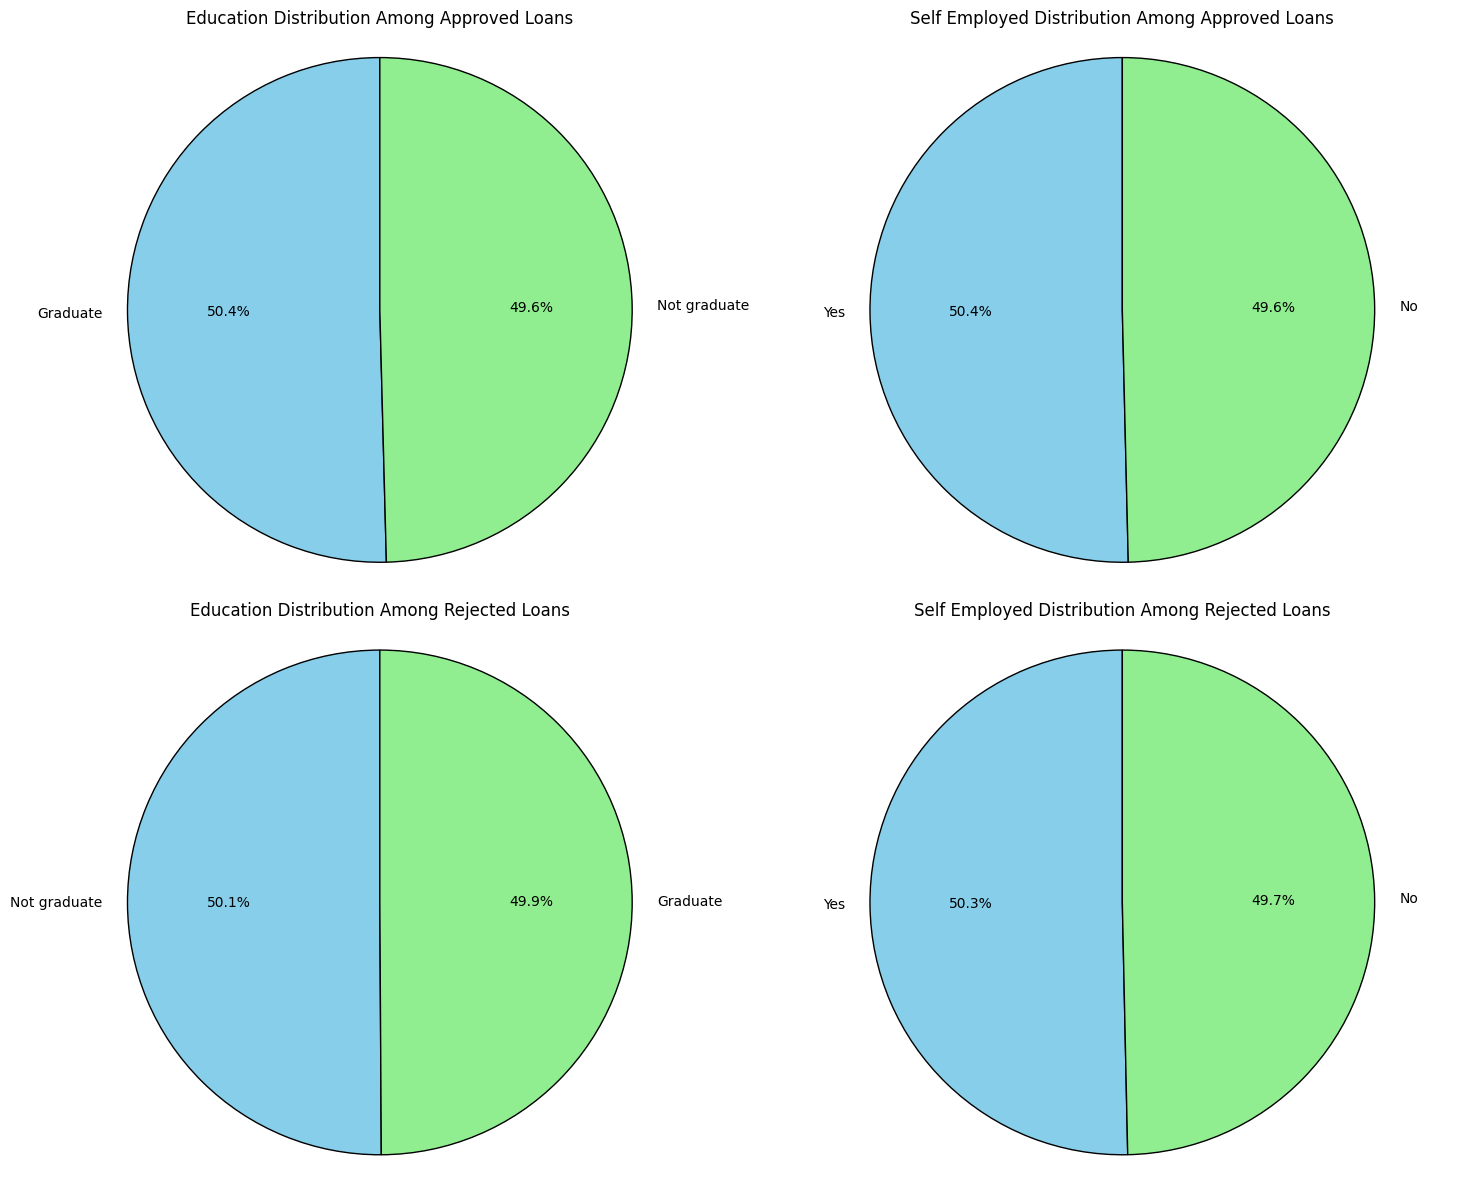

In [77]:
colors = ['skyblue', 'lightgreen', 'salmon', 'gold', 'orchid', 'lightcoral', 'lightblue', 'lightsalmon', 'lightseagreen']

for column in loan_data.select_dtypes(include=['object']).columns:
    loan_data[column] = loan_data[column].str.strip().str.capitalize()


approved_loan_data = loan_data[loan_data['loan_status'] == 'Approved']
rejected_loan_data = loan_data[loan_data['loan_status'] == 'Rejected']


education_counts_approved = approved_loan_data['education'].value_counts()
self_employed_counts_approved = approved_loan_data['self_employed'].value_counts()

education_counts_rejected = rejected_loan_data['education'].value_counts()
self_employed_counts_rejected = rejected_loan_data['self_employed'].value_counts()


fig, axs = plt.subplots(2, 2, figsize=(15, 12))


axs[0, 0].pie(education_counts_approved, labels=education_counts_approved.index, autopct='%1.1f%%', startangle=90, colors=colors[:len(education_counts_approved)],
              wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axs[0, 0].set_title('Education Distribution Among Approved Loans')
axs[0, 0].axis('equal')


axs[0, 1].pie(self_employed_counts_approved, labels=self_employed_counts_approved.index, autopct='%1.1f%%', startangle=90, colors=colors[:len(self_employed_counts_approved)],
              wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axs[0, 1].set_title('Self Employed Distribution Among Approved Loans')
axs[0, 1].axis('equal')


axs[1, 0].pie(education_counts_rejected, labels=education_counts_rejected.index, autopct='%1.1f%%', startangle=90, colors=colors[:len(education_counts_rejected)],
              wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axs[1, 0].set_title('Education Distribution Among Rejected Loans')
axs[1, 0].axis('equal')


axs[1, 1].pie(self_employed_counts_rejected, labels=self_employed_counts_rejected.index, autopct='%1.1f%%', startangle=90, colors=colors[:len(self_employed_counts_rejected)],
              wedgeprops={'edgecolor': 'black', 'linewidth': 1, 'antialiased': True})
axs[1, 1].set_title('Self Employed Distribution Among Rejected Loans')
axs[1, 1].axis('equal')


plt.tight_layout()
plt.show()

**Education Distribution:**

The distribution of education levels (Graduate vs. Not Graduate) is almost equal among both approved and rejected loan applicants.

For approved loans, 50.4% of applicants are graduates, while 49.6% are not graduates.

For rejected loans, the proportions are similar, with 49.9% graduates and 50.1% not graduates.

This suggests that education level may not be a significant differentiator between approved and rejected loan applicants in this dataset.

**Self-Employed Distribution:**

The distribution of self-employment status (Yes vs. No) is also almost equal among both approved and rejected loan applicants.

For approved loans, 50.4% of applicants are self-employed, while 49.6% are not.

For rejected loans, the proportions are very close, with 50.3% self-employed and 49.7% not self-employed.

Similar to education, self-employment status does not show a clear distinction between approved and rejected loans.

# 3.Creating New Features


In [78]:
# Feature 1: Income-to-Loan Ratio
loan_data['income_to_loan_ratio'] = loan_data['income_annum'] / loan_data['loan_amount']

# Feature 2: Total Asset Value
loan_data['total_assets_value'] = (loan_data['residential_assets_value'] +
                                   loan_data['commercial_assets_value'] +
                                   loan_data['luxury_assets_value'] +
                                   loan_data['bank_asset_value'])

# Feature 3: Loan-to-Asset Ratio
loan_data['loan_to_asset_ratio'] = loan_data['loan_amount'] / loan_data['total_assets_value']

# Feature 4: Dependents-to-Income Ratio
loan_data['dependents_to_income_ratio'] = loan_data['no_of_dependents'] / loan_data['income_annum']

# Feature 5: Loan Term Category
loan_data['loan_term_category'] = pd.cut(loan_data['loan_term'], bins=[0, 10, 20, 30],
                                         labels=['Short Term', 'Medium Term', 'Long Term'])

# Feature 6: Employment and Education Interaction
loan_data['employment_education_interaction'] = loan_data['self_employed'] + '_' + loan_data['education']

# Feature 7: Asset to Income Ratio
loan_data['asset_to_income_ratio'] = loan_data['total_assets_value'] / loan_data['income_annum']

# Feature 8: Annual Loan Payment
loan_data['annual_loan_payment'] = loan_data['loan_amount'] / loan_data['loan_term']

# Feature 9: Debt-to-Income Ratio
loan_data['debt_to_income_ratio'] = loan_data['loan_amount'] / loan_data['income_annum']

# Feature 10: Average Asset Value
loan_data['average_asset_value'] = loan_data[['residential_assets_value', 'commercial_assets_value', 'luxury_assets_value', 'bank_asset_value']].mean(axis=1)

# Feature 11: Loan Payment Burden
loan_data['loan_payment_burden'] = loan_data['loan_amount'] / loan_data['income_annum']

# Feature 12: Asset income interaction
loan_data['asset_income_interaction'] = loan_data['total_assets_value'] * loan_data['income_annum']

In [79]:
loan_data.describe().T

,count,mean,std,min,25%,50%,75%,max
loan_id,4269.000,2135.000,1232.498,1.000,1068.000,2135.000,3202.000,4269.000
no_of_dependents,4269.000,2.499,1.696,0.000,1.000,3.000,4.000,5.000
income_annum,4269.000,5059123.917,2806839.832,200000.000,2700000.000,5100000.000,7500000.000,9900000.000
loan_amount,4269.000,15133450.457,9043362.985,300000.000,7700000.000,14500000.000,21500000.000,39500000.000
loan_term,4269.000,10.900,5.709,2.000,6.000,10.000,16.000,20.000
cibil_score,4269.000,599.936,172.430,300.000,453.000,600.000,748.000,900.000
residential_assets_value,4269.000,7472616.538,6503636.588,-100000.000,2200000.000,5600000.000,11300000.000,29100000.000
commercial_assets_value,4269.000,4973155.306,4388966.090,0.000,1300000.000,3700000.000,7600000.000,19400000.000
luxury_assets_value,4269.000,15126305.926,9103753.665,300000.000,7500000.000,14600000.000,21700000.000,39200000.000
bank_asset_value,4269.000,4971398.454,3231546.912,200000.000,2300000.000,4600000.000,7100000.000,13100000.000


In [80]:
for column in loan_data.columns:
    if loan_data[column].nunique() == 1:
        loan_data.drop(column, axis=1, inplace=True)

In [81]:
# Map loan_status to numerical values
loan_data['loan_status'] = loan_data['loan_status'].map({'Approved': 1, 'Rejected': 0})

In [82]:
cats = loan_data.select_dtypes(include=["object", "category"]).columns.tolist()
cats

['education',
 'self_employed',
 'loan_term_category',
 'employment_education_interaction']

In [83]:
nums=loan_data.select_dtypes(exclude=["object","category"]).columns.drop(['loan_id','loan_status']).tolist()
nums

['no_of_dependents',
 'income_annum',
 'loan_amount',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value',
 'luxury_assets_value',
 'bank_asset_value',
 'income_to_loan_ratio',
 'total_assets_value',
 'loan_to_asset_ratio',
 'dependents_to_income_ratio',
 'asset_to_income_ratio',
 'annual_loan_payment',
 'debt_to_income_ratio',
 'average_asset_value',
 'loan_payment_burden',
 'asset_income_interaction']

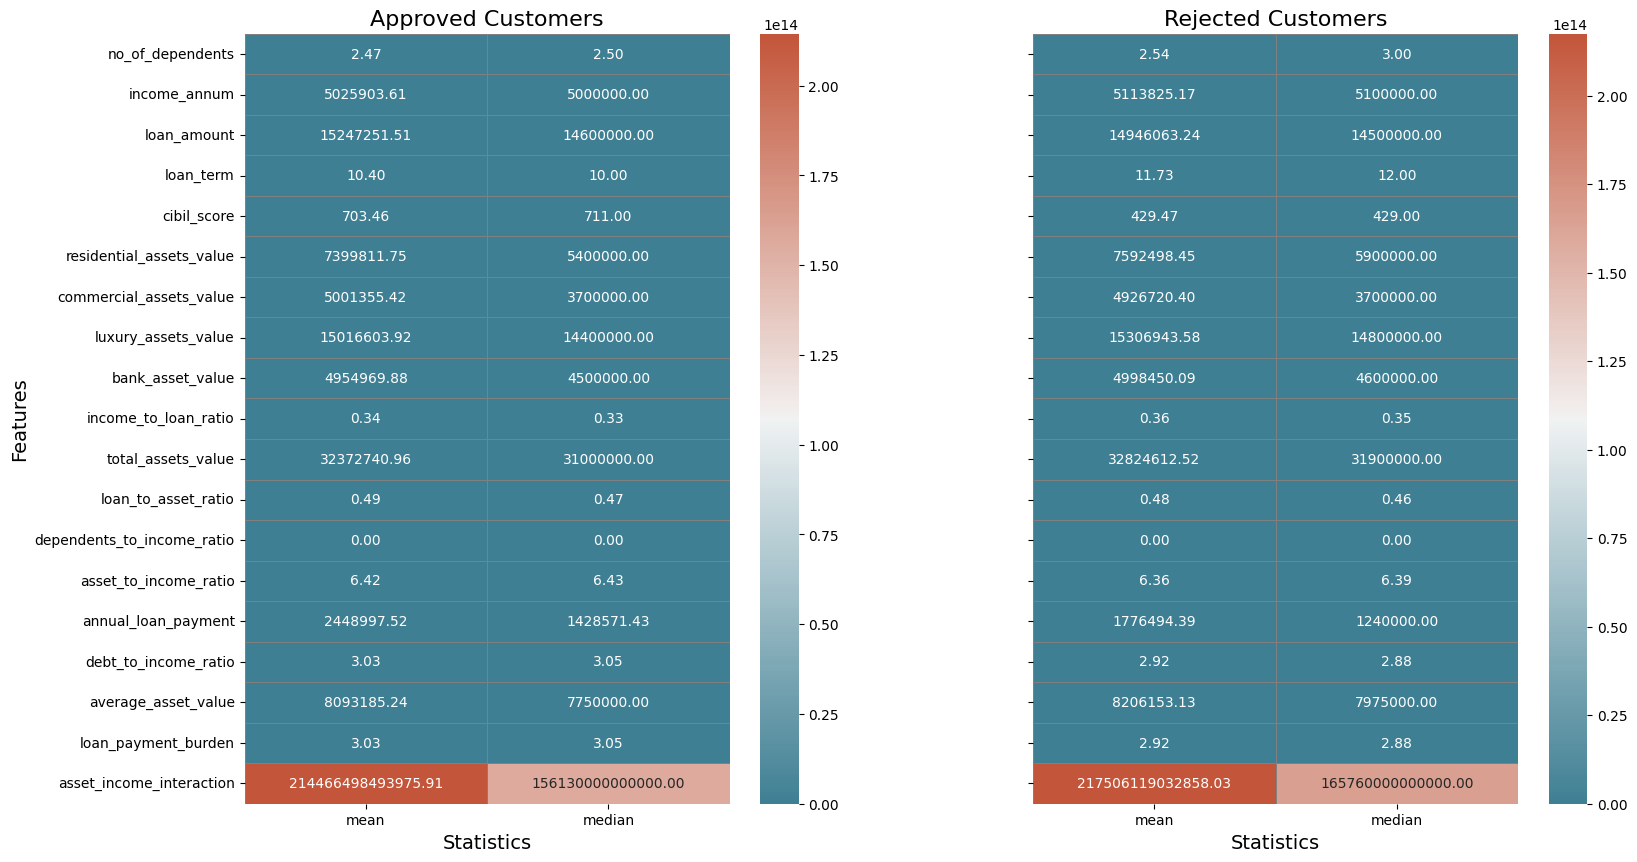

In [84]:

approved = loan_data[loan_data['loan_status'] == 1][nums].describe().T
rejected = loan_data[loan_data['loan_status'] == 0][nums].describe().T


approved_stats = approved[['mean', '50%']]
rejected_stats = rejected[['mean', '50%']]


approved_stats.rename(columns={'50%': 'median'}, inplace=True)
rejected_stats.rename(columns={'50%': 'median'}, inplace=True)


cmap = sns.diverging_palette(220, 20, as_cmap=True)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10), sharey=True)


sns.heatmap(approved_stats, annot=True, cmap=cmap, linewidths=0.5, linecolor='grey', cbar=True, fmt='.2f',
            annot_kws={"size": 10}, ax=ax[0])
ax[0].set_title('Approved Customers', fontsize=16)
ax[0].set_ylabel('Features', fontsize=14)
ax[0].set_xlabel('Statistics', fontsize=14)


sns.heatmap(rejected_stats, annot=True, cmap=cmap, linewidths=0.5, linecolor='grey', cbar=True, fmt='.2f',
            annot_kws={"size": 10}, ax=ax[1])
ax[1].set_title('Rejected Customers', fontsize=16)
ax[1].set_xlabel('Statistics', fontsize=14)


plt.subplots_adjust(wspace=0.3)


plt.show()

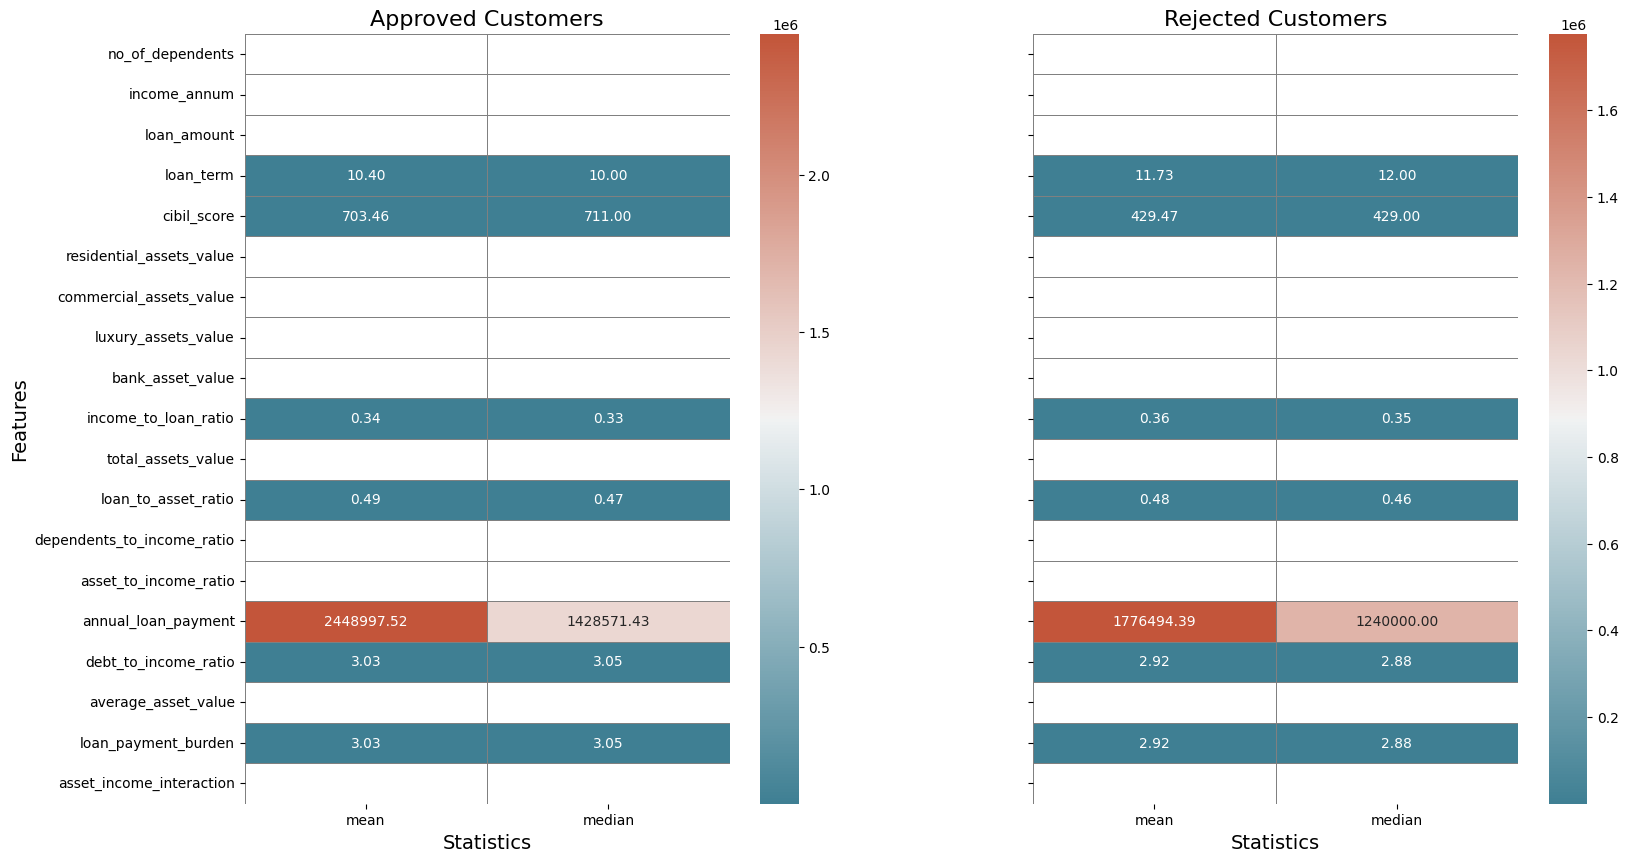

Features with significant differences between approved and rejected customers:
                      p_value  significant
Feature                                   
loan_term               0.000         True
cibil_score             0.000         True
income_to_loan_ratio    0.000         True
loan_to_asset_ratio     0.047         True
annual_loan_payment     0.000         True
debt_to_income_ratio    0.000         True
loan_payment_burden     0.000         True


In [85]:



approved = loan_data[loan_data['loan_status'] == 1][nums].describe().T
rejected = loan_data[loan_data['loan_status'] == 0][nums].describe().T


results = {}
for feature in nums:
    approved_values = loan_data[loan_data['loan_status'] == 1][feature]
    rejected_values = loan_data[loan_data['loan_status'] == 0][feature]

    approved_values = pd.to_numeric(approved_values, errors='coerce').dropna()
    rejected_values = pd.to_numeric(rejected_values, errors='coerce').dropna()
    t_stat, p_value = ttest_ind(approved_values, rejected_values, equal_var=False)
    results[feature] = p_value


p_values = pd.DataFrame(list(results.items()), columns=['Feature', 'p_value'])
p_values.set_index('Feature', inplace=True)


alpha = 0.05


p_values['significant'] = p_values['p_value'] < alpha


approved_stats = approved[['mean', '50%']].merge(p_values, left_index=True, right_index=True)
rejected_stats = rejected[['mean', '50%']].merge(p_values, left_index=True, right_index=True)


approved_stats.rename(columns={'50%': 'median'}, inplace=True)
rejected_stats.rename(columns={'50%': 'median'}, inplace=True)

mask_approved = approved_stats[['mean', 'median']].apply(lambda x: ~approved_stats['significant'], axis=0)
mask_rejected = rejected_stats[['mean', 'median']].apply(lambda x: ~rejected_stats['significant'], axis=0)


cmap = sns.diverging_palette(220, 20, as_cmap=True)


fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10), sharey=True)


sns.heatmap(approved_stats[['mean', 'median']], annot=True, cmap=cmap, linewidths=0.5, linecolor='grey', cbar=True, fmt='.2f',
            annot_kws={"size": 10}, ax=ax[0], mask=mask_approved)
ax[0].set_title('Approved Customers', fontsize=16)
ax[0].set_ylabel('Features', fontsize=14)
ax[0].set_xlabel('Statistics', fontsize=14)


sns.heatmap(rejected_stats[['mean', 'median']], annot=True, cmap=cmap, linewidths=0.5, linecolor='grey', cbar=True, fmt='.2f',
            annot_kws={"size": 10}, ax=ax[1], mask=mask_rejected)
ax[1].set_title('Rejected Customers', fontsize=16)
ax[1].set_xlabel('Statistics', fontsize=14)


plt.subplots_adjust(wspace=0.3)


plt.show()


significant_features = p_values[p_values['significant']]
print("Features with significant differences between approved and rejected customers:")
print(significant_features)

# 4. Build Model

In [86]:
loan_data = loan_data.set_index("loan_id")


In [87]:
cats = loan_data.select_dtypes(include=["object", "category"]).columns.tolist()


cats

['education',
 'self_employed',
 'loan_term_category',
 'employment_education_interaction']

In [88]:

nums=loan_data.select_dtypes(exclude=["object", "category"]).columns.drop(['loan_status']).tolist()
nums


['no_of_dependents',
 'income_annum',
 'loan_amount',
 'loan_term',
 'cibil_score',
 'residential_assets_value',
 'commercial_assets_value',
 'luxury_assets_value',
 'bank_asset_value',
 'income_to_loan_ratio',
 'total_assets_value',
 'loan_to_asset_ratio',
 'dependents_to_income_ratio',
 'asset_to_income_ratio',
 'annual_loan_payment',
 'debt_to_income_ratio',
 'average_asset_value',
 'loan_payment_burden',
 'asset_income_interaction']

In [35]:
# Encode categorical variables
label_encoders = {}
for column in cats:
    le = LabelEncoder()
    loan_data[column] = le.fit_transform(loan_data[column])
    label_encoders[column] = le

In [79]:
X = loan_data.drop(["loan_status"], axis=1)
y = loan_data["loan_status"]


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)


**Trial 1: LightGBM Model**

A trial was conducted with the LightGBM model. It was observed that because of the cibil score variable, the model makes predictions based only on this single variable, ignoring other variables.

P.S: In loan prediction, the F1 Macro score is important because it equally considers both loan approvals and rejections, even with imbalanced data.

It balances precision (correct approvals) and recall (identifying all approved loans), ensuring fair and accurate predictions for both classes. This helps avoid bias towards the majority class and provides a more reliable assessment of model performance.




In [ ]:

param_ranges = {
    'num_leaves': (30, 50),
    'learning_rate': (0.005, 0.1),
    'n_estimators': (100, 300),
    'max_depth': (1, 4),
    'min_child_samples': (2, 10),
    'scale_pos_weight': (1, 5),
    'colsample_bytree': (0.6, 1.0),
    'subsample': (0.6, 1.0),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0)
}

lgbm = LGBMClassifier(random_state=23, objective='binary', boosting_type='gbdt')

bayes_search = BayesSearchCV(
    lgbm,
    param_ranges,
    n_iter=60,
    cv=10,
    scoring="f1_macro",
    random_state=23,
    verbose=-1
)

bayes_search.fit(X_train, y_train)

In [81]:

print("Best Parameters:", bayes_search.best_params_)

best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: OrderedDict([('colsample_bytree', 0.6834593011923544), ('learning_rate', 0.09650225401288882), ('max_depth', 3), ('min_child_samples', 2), ('n_estimators', 205), ('num_leaves', 46), ('reg_alpha', 0.40103249972383204), ('reg_lambda', 0.9064897606426882), ('scale_pos_weight', 1), ('subsample', 0.6229725333578721)])
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       654
           1       1.00      1.00      1.00      1054

    accuracy                           1.00      1708
   macro avg       1.00      1.00      1.00      1708
weighted avg       1.00      1.00      1.00      1708



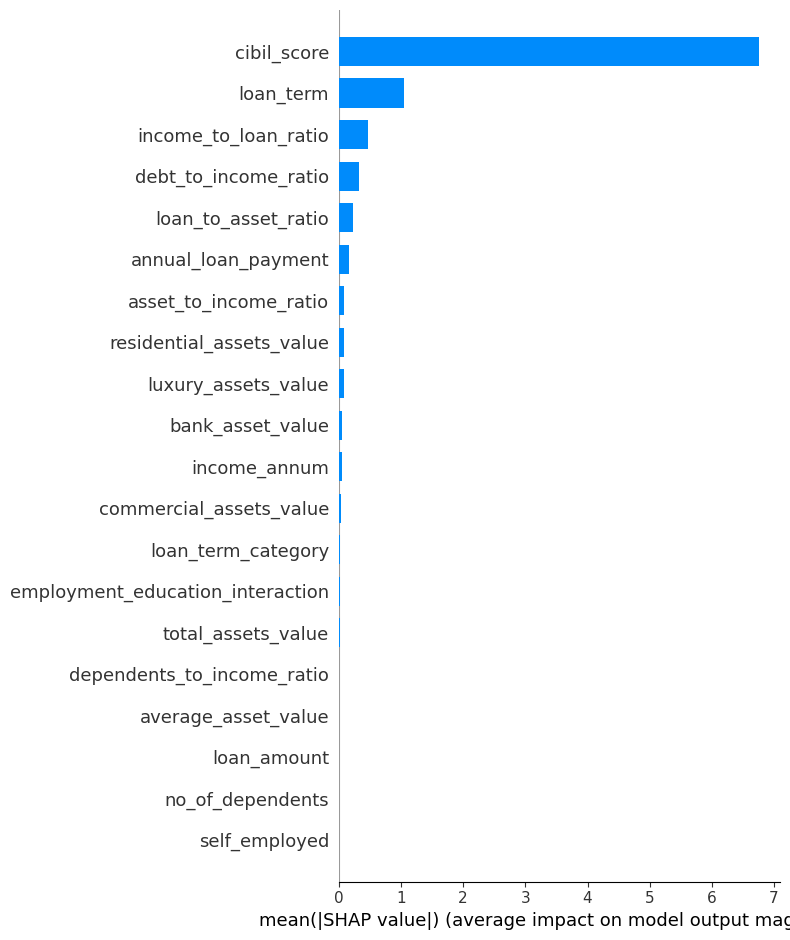

In [82]:
explainer = shap.TreeExplainer(best_model)

# Calculate SHAP values for the training set
shap_values = explainer.shap_values(X_train)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_train, plot_type="bar", feature_names=X_train.columns)

In [83]:
# Calculate the mean absolute SHAP values for each feature
mean_abs_shap_values = np.abs(shap_values).mean(axis=0)

feature_names = X_train.columns.tolist()


importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': mean_abs_shap_values
}).sort_values(by='SHAP Importance', ascending=False)

importance_df

,Feature,SHAP Importance
6,cibil_score,6.758
5,loan_term,1.054
11,income_to_loan_ratio,0.476
19,debt_to_income_ratio,0.317
13,loan_to_asset_ratio,0.225
18,annual_loan_payment,0.161
17,asset_to_income_ratio,0.086
7,residential_assets_value,0.081
9,luxury_assets_value,0.075
10,bank_asset_value,0.057


The results were analyzed by building a model using only the cibil score, and then a rule-based structure was created using a decision tree to understand the current situation.

In [42]:
X = loan_data[["cibil_score"]]
y = loan_data["loan_status"]


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:

param_ranges = {
    'num_leaves': (30, 50),
    'learning_rate': (0.005, 0.1),
    'n_estimators': (100, 300),
    'max_depth': (1, 4),
    'min_child_samples': (2, 10),
    'scale_pos_weight': (1, 5),
    'colsample_bytree': (0.6, 1.0),
    'subsample': (0.6, 1.0),
    'reg_alpha': (0.0, 1.0),
    'reg_lambda': (0.0, 1.0)
}

lgbm = LGBMClassifier(random_state=23, objective='binary', boosting_type='gbdt')

bayes_search = BayesSearchCV(
    lgbm,
    param_ranges,
    n_iter=60,
    cv=10,
    scoring="f1_macro",
    random_state=23,
    verbose=-1
)

bayes_search.fit(X_train, y_train)

In [44]:

print("Best Parameters:", bayes_search.best_params_)

best_model = bayes_search.best_estimator_
y_pred = best_model.predict(X_test)

print("Classification Report:\n", classification_report(y_test, y_pred))

Best Parameters: OrderedDict([('colsample_bytree', 0.8725869814330554), ('learning_rate', 0.029175432255297683), ('max_depth', 2), ('min_child_samples', 4), ('n_estimators', 168), ('num_leaves', 48), ('reg_alpha', 0.7903060099337398), ('reg_lambda', 0.9477015271022344), ('scale_pos_weight', 1), ('subsample', 0.6037040155283954)])
Classification Report:
               precision    recall  f1-score   support

           0       0.89      0.99      0.94       654
           1       1.00      0.92      0.96      1054

    accuracy                           0.95      1708
   macro avg       0.94      0.96      0.95      1708
weighted avg       0.96      0.95      0.95      1708



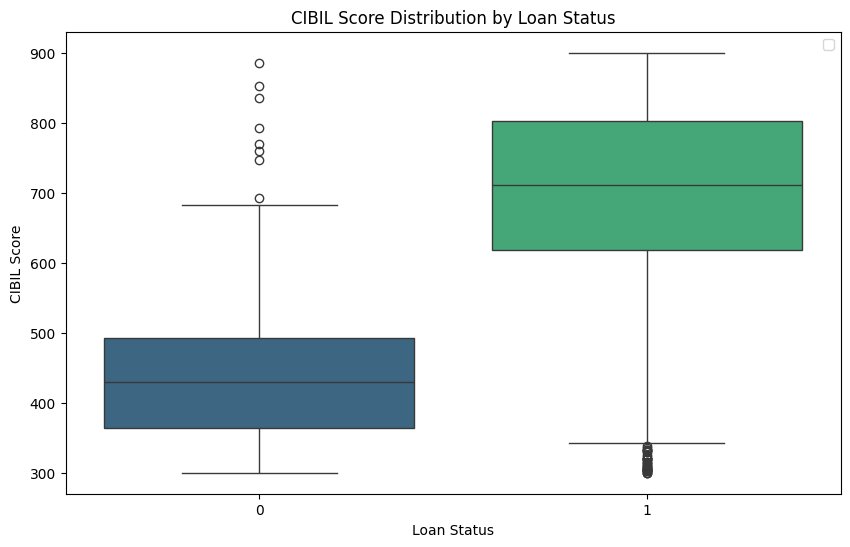

In [45]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='loan_status', y='cibil_score', data=loan_data, palette='viridis')
plt.title('CIBIL Score Distribution by Loan Status')
plt.xlabel('Loan Status')
plt.ylabel('CIBIL Score')
plt.legend()
plt.show()

In [46]:
X = loan_data.drop(["loan_status"], axis=1)
y = loan_data["loan_status"]



X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [48]:

param_ranges = {
    'max_depth': Integer(1, 5),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
    'max_features': Real(0.6, 1.0)
}


dt = DecisionTreeClassifier(random_state=23)


bayes_search = BayesSearchCV(
    dt,
    param_ranges,
    n_iter=60,
    cv=10,
    scoring="f1_macro",
    random_state=23,
    verbose=-1
)


bayes_search.fit(X_train, y_train)


print("Best parameters found: ", bayes_search.best_params_)
print("Best score: ", bayes_search.best_score_)


Best parameters found:  OrderedDict([('max_depth', 5), ('max_features', 0.6), ('min_samples_leaf', 1), ('min_samples_split', 2)])
Best score:  0.9991631076292524


In [99]:
class_values = y_train.unique()
class_values.sort()
class_names = ['Rejected' if value == 0 else 'Approved' for value in class_values]

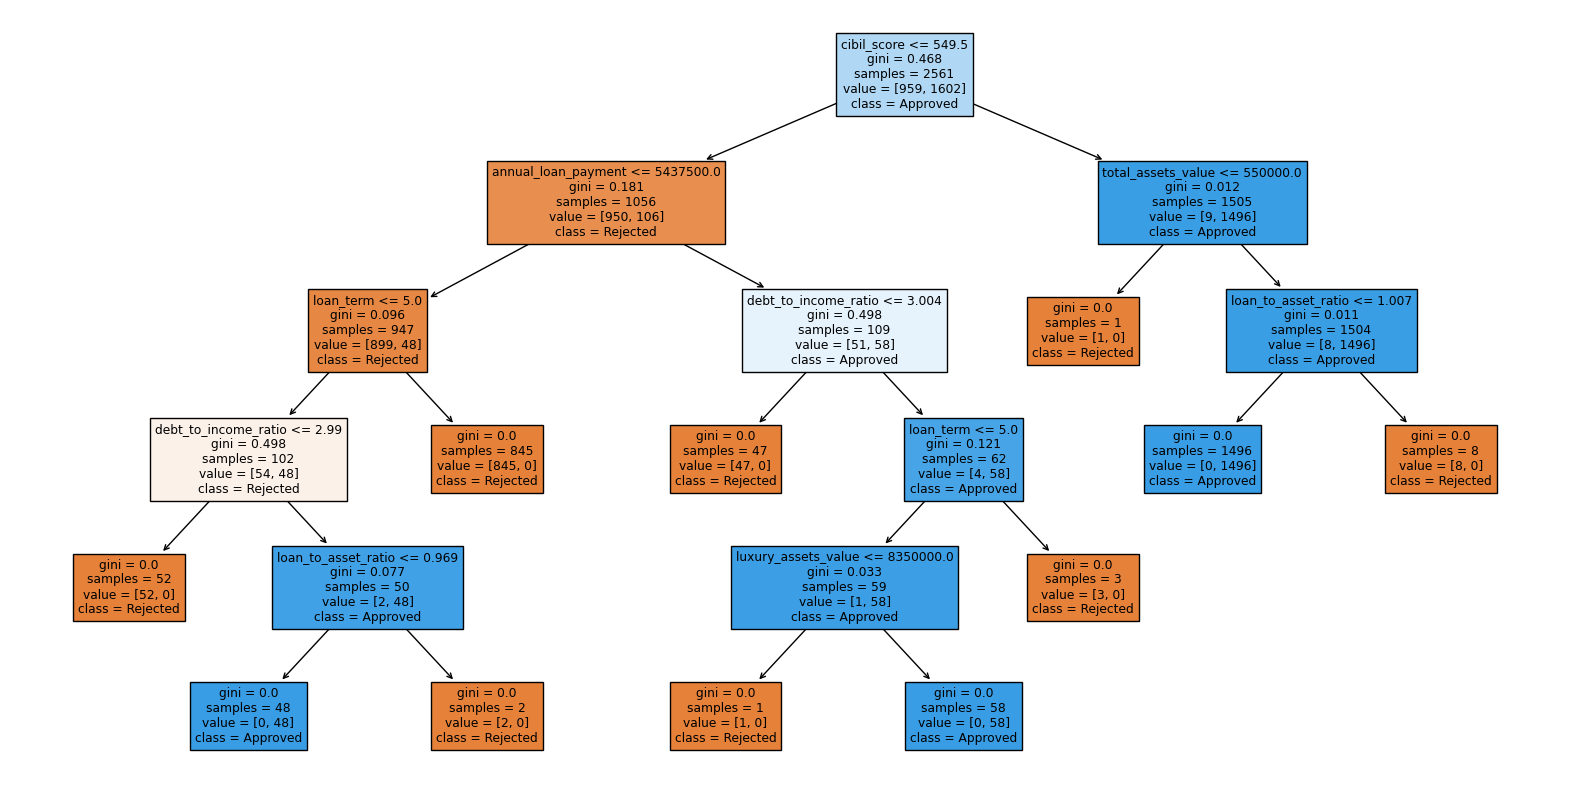

In [57]:

best_model = bayes_search.best_estimator_


from sklearn.tree import DecisionTreeClassifier, plot_tree
plt.figure(figsize=(20,10))
plot_tree(best_model, filled=True, feature_names=X_train.columns, class_names=class_names)
plt.show()

Currently, approval and rejection decisions are made based on a rule-based structure dependent on the cibil score.

Since this variable creates bias, it was directly removed from the model data, and experiments were conducted using Random Forest and LightGBM models.

**Trial 2: LightGBM & RF Models**

A model was created by removing the cibil score and changing the parameter ranges, but the results did not perform well.


In [97]:
X = loan_data.drop(["loan_status","cibil_score"], axis=1)
y = loan_data["loan_status"]


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

In [ ]:

param_ranges_rf = {
    'max_depth': Integer(1, 10),
    'min_samples_split': Integer(2, 40),
    'min_samples_leaf': Integer(1, 40),
    'max_features': Real(0.4, 1.0),
    'n_estimators': Integer(100, 300)
}

param_ranges_lgbm = {
    'num_leaves': Integer(30, 50),
    'learning_rate': Real(0.005, 0.1),
    'n_estimators': Integer(100, 300),
    'max_depth': Integer(1, 10),
    'min_child_samples': Integer(2, 20),
    'colsample_bytree': Real(0.6, 1.0),
    'subsample': Real(0.6, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0)
}

def train_and_optimize(model, param_ranges, X_train, y_train):
    bayes_search = BayesSearchCV(
        model,
        param_ranges,
        n_iter=60,
        cv=5,
        scoring="f1_macro",
        random_state=23,
        verbose=1
    )
    bayes_search.fit(X_train, y_train)
    return bayes_search


rf = RandomForestClassifier(random_state=23)
bayes_search_rf = train_and_optimize(rf, param_ranges_rf, X_train, y_train)
best_model_rf = bayes_search_rf.best_estimator_


lgbm = LGBMClassifier(random_state=23, objective='binary', boosting_type='gbdt')
bayes_search_lgbm = train_and_optimize(lgbm, param_ranges_lgbm, X_train, y_train)
best_model_lgbm = bayes_search_lgbm.best_estimator_




In [101]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=class_names)
    return report


print("Random Forest Best parameters found: ", bayes_search_rf.best_params_)
print("LightGBM Best parameters found: ", bayes_search_lgbm.best_params_)

print("\nRandom Forest Classification Report:\n", evaluate_model(best_model_rf, X_test, y_test))
print("\nLightGBM Classification Report:\n", evaluate_model(best_model_lgbm, X_test, y_test))


Random Forest Best parameters found:  OrderedDict([('max_depth', 10), ('max_features', 0.7512678083769379), ('min_samples_leaf', 1), ('min_samples_split', 2), ('n_estimators', 100)])
LightGBM Best parameters found:  OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.1), ('max_depth', 6), ('min_child_samples', 2), ('n_estimators', 300), ('num_leaves', 30), ('reg_alpha', 0.9425344327513253), ('reg_lambda', 1.0), ('subsample', 0.6)])

Random Forest Classification Report:
               precision    recall  f1-score   support

    Rejected       0.42      0.10      0.16       654
    Approved       0.62      0.91      0.74      1054

    accuracy                           0.60      1708
   macro avg       0.52      0.51      0.45      1708
weighted avg       0.54      0.60      0.52      1708


LightGBM Classification Report:
               precision    recall  f1-score   support

    Rejected       0.46      0.32      0.38       654
    Approved       0.65      0.77      0.70    

**Trial 3: LightGBM & RF Models**

The parameter ranges were changed, and class weights were added due to imbalanced data. The results are better than the previous version.

In [106]:

class_weights = dict(pd.Series(y_train).value_counts(normalize=True))
scale_pos_weight = class_weights[0] / class_weights[1]


param_ranges_rf = {
    'max_depth': Integer(1, 15),
    'min_samples_split': Integer(2, 50),
    'min_samples_leaf': Integer(1, 50),
    'max_features': Real(0.2, 1.0),
    'n_estimators': Integer(50, 400),
    'class_weight': ['balanced']
}

param_ranges_lgbm = {
    'num_leaves': Integer(20, 60),
    'learning_rate': Real(0.001, 0.2),
    'n_estimators': Integer(100, 500),
    'max_depth': Integer(1, 15),
    'min_child_samples': Integer(1, 50),
    'colsample_bytree': Real(0.4, 1.0),
    'subsample': Real(0.4, 1.0),
    'reg_alpha': Real(0.0, 1.0),
    'reg_lambda': Real(0.0, 1.0),
    'scale_pos_weight': Real(0.5, scale_pos_weight)
}

In [ ]:

rf = RandomForestClassifier(random_state=23)
bayes_search_rf = train_and_optimize(rf, param_ranges_rf, X_train, y_train)
best_model_rf = bayes_search_rf.best_estimator_


lgbm = LGBMClassifier(random_state=23, objective='binary', boosting_type='gbdt')
bayes_search_lgbm = train_and_optimize(lgbm, param_ranges_lgbm, X_train, y_train)
best_model_lgbm = bayes_search_lgbm.best_estimator_


In [108]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=class_names)
    return report

print("Random Forest Best parameters found: ", bayes_search_rf.best_params_)
print("LightGBM Best parameters found: ", bayes_search_lgbm.best_params_)

print("\nRandom Forest Classification Report:\n", evaluate_model(best_model_rf, X_test, y_test))
print("\nLightGBM Classification Report:\n", evaluate_model(best_model_lgbm, X_test, y_test))


Random Forest Best parameters found:  OrderedDict([('class_weight', 'balanced'), ('max_depth', 10), ('max_features', 0.4897795587712084), ('min_samples_leaf', 21), ('min_samples_split', 2), ('n_estimators', 400)])
LightGBM Best parameters found:  OrderedDict([('colsample_bytree', 1.0), ('learning_rate', 0.2), ('max_depth', 15), ('min_child_samples', 1), ('n_estimators', 226), ('num_leaves', 20), ('reg_alpha', 0.0), ('reg_lambda', 0.0), ('scale_pos_weight', 0.5), ('subsample', 0.4)])

Random Forest Classification Report:
               precision    recall  f1-score   support

    Rejected       0.44      0.64      0.52       654
    Approved       0.69      0.50      0.58      1054

    accuracy                           0.56      1708
   macro avg       0.57      0.57      0.55      1708
weighted avg       0.60      0.56      0.56      1708


LightGBM Classification Report:
               precision    recall  f1-score   support

    Rejected       0.45      0.41      0.43       654
   

**LightGBM Feature Importances with SHAP Values**

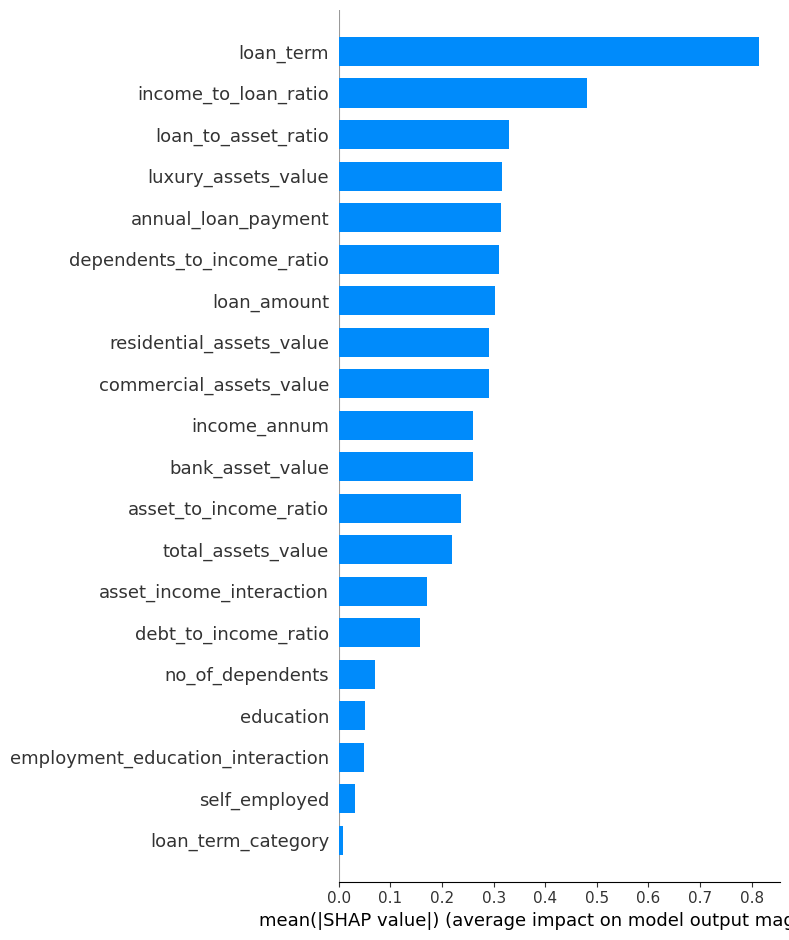

In [109]:
explainer_lgbm = shap.TreeExplainer(best_model_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_train)
shap.summary_plot(shap_values_lgbm, X_train, plot_type="bar", feature_names=X_train.columns)

In [114]:
mean_abs_shap_values = np.abs(shap_values_lgbm).mean(axis=0)

feature_names = X_train.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': mean_abs_shap_values
}).sort_values(by='SHAP Importance', ascending=False)

importance_df

,Feature,SHAP Importance
5,loan_term,0.814
10,income_to_loan_ratio,0.481
12,loan_to_asset_ratio,0.329
8,luxury_assets_value,0.315
17,annual_loan_payment,0.315
13,dependents_to_income_ratio,0.311
4,loan_amount,0.303
6,residential_assets_value,0.292
7,commercial_assets_value,0.292
3,income_annum,0.260


**Trial 4:**

New features were added based on SHAP values, and the test size was reduced from 0.4 to 0.2.

In [90]:

loan_data['loan_term_income_to_loan_ratio'] = loan_data['loan_term'] * loan_data['income_to_loan_ratio']
loan_data['loan_to_asset_annual_loan_payment'] = loan_data['loan_to_asset_ratio'] * loan_data['annual_loan_payment']
loan_data['luxury_commercial_assets_value'] = loan_data['luxury_assets_value'] * loan_data['commercial_assets_value']

In [38]:
X = loan_data.drop(["loan_status","cibil_score"], axis=1)
y = loan_data["loan_status"]


# Train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.8, random_state=42)

In [ ]:
rf = RandomForestClassifier(random_state=23)
bayes_search_rf = train_and_optimize(rf, param_ranges_rf, X_train, y_train)
best_model_rf = bayes_search_rf.best_estimator_


lgbm = LGBMClassifier(random_state=23, objective='binary', boosting_type='gbdt')
bayes_search_lgbm = train_and_optimize(lgbm, param_ranges_lgbm, X_train, y_train)
best_model_lgbm = bayes_search_lgbm.best_estimator_

In [119]:

def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    report = classification_report(y_test, y_pred, target_names=class_names)
    return report

print("Random Forest Best parameters found: ", bayes_search_rf.best_params_)
print("LightGBM Best parameters found: ", bayes_search_lgbm.best_params_)

print("\nRandom Forest Classification Report:\n", evaluate_model(best_model_rf, X_test, y_test))
print("\nLightGBM Classification Report:\n", evaluate_model(best_model_lgbm, X_test, y_test))

Random Forest Best parameters found:  OrderedDict([('class_weight', 'balanced'), ('max_depth', 14), ('max_features', 1.0), ('min_samples_leaf', 23), ('min_samples_split', 17), ('n_estimators', 51)])
LightGBM Best parameters found:  OrderedDict([('colsample_bytree', 0.7291466525639625), ('learning_rate', 0.029441720348549735), ('max_depth', 4), ('min_child_samples', 50), ('n_estimators', 444), ('num_leaves', 35), ('reg_alpha', 0.7149666523000501), ('reg_lambda', 0.05141520113145012), ('scale_pos_weight', 0.5818323016479162), ('subsample', 0.6170433155330619)])

Random Forest Classification Report:
               precision    recall  f1-score   support

    Rejected       0.42      0.56      0.48      1297
    Approved       0.66      0.52      0.58      2119

    accuracy                           0.54      3416
   macro avg       0.54      0.54      0.53      3416
weighted avg       0.57      0.54      0.54      3416


LightGBM Classification Report:
               precision    recall 

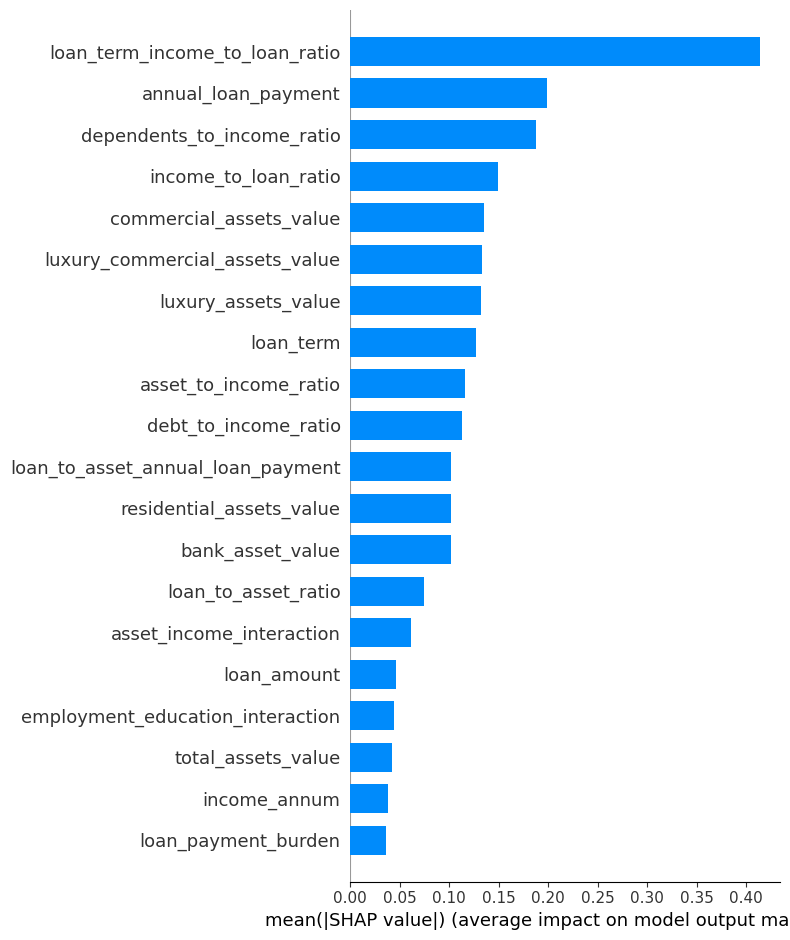

In [120]:
explainer_lgbm = shap.TreeExplainer(best_model_lgbm)
shap_values_lgbm = explainer_lgbm.shap_values(X_train)
shap.summary_plot(shap_values_lgbm, X_train, plot_type="bar", feature_names=X_train.columns)

In [121]:
mean_abs_shap_values = np.abs(shap_values_lgbm).mean(axis=0)

feature_names = X_train.columns.tolist()

importance_df = pd.DataFrame({
    'Feature': feature_names,
    'SHAP Importance': mean_abs_shap_values
}).sort_values(by='SHAP Importance', ascending=False)

importance_df

,Feature,SHAP Importance
24,loan_term_income_to_loan_ratio,0.413
17,annual_loan_payment,0.199
13,dependents_to_income_ratio,0.188
10,income_to_loan_ratio,0.150
7,commercial_assets_value,0.135
26,luxury_commercial_assets_value,0.133
8,luxury_assets_value,0.132
5,loan_term,0.127
16,asset_to_income_ratio,0.116
18,debt_to_income_ratio,0.113


**Trial : 5**

Tuning was performed using Optuna. The RF and LGBM models performed poorly.

In [ ]:

def objective_lgbm(trial):
    param = {
        'num_leaves': trial.suggest_int('num_leaves', 20, 70),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.2),
        'n_estimators': trial.suggest_int('n_estimators', 100, 500),
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.4, 1.0),
        'subsample': trial.suggest_uniform('subsample', 0.4, 1.0),
        'reg_alpha': trial.suggest_uniform('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_uniform('reg_lambda', 0.0, 1.0),
        'scale_pos_weight': trial.suggest_uniform('scale_pos_weight', 0.5, 2)
    }

    model = lgb.LGBMClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro')
    return scores.mean()


def objective_rf(trial):
    param = {
        'max_depth': trial.suggest_int('max_depth', 1, 25),
        'min_samples_split': trial.suggest_int('min_samples_split', 2, 50),
        'min_samples_leaf': trial.suggest_int('min_samples_leaf', 1, 50),
        'max_features': trial.suggest_uniform('max_features', 0.2, 1.0),
        'n_estimators': trial.suggest_int('n_estimators', 50, 400),
        'class_weight': 'balanced'
    }

    model = RandomForestClassifier(**param)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = cross_val_score(model, X_train, y_train, cv=skf, scoring='f1_macro')
    return scores.mean()


study_lgbm = optuna.create_study(direction='maximize')
study_lgbm.optimize(objective_lgbm, n_trials=50)


study_rf = optuna.create_study(direction='maximize')
study_rf.optimize(objective_rf, n_trials=50)


best_lgbm_params = study_lgbm.best_params
best_rf_params = study_rf.best_params

print("Best LightGBM params:", best_lgbm_params)
print("Best RandomForest params:", best_rf_params)


best_lgbm_model = lgb.LGBMClassifier(**best_lgbm_params)
best_rf_model = RandomForestClassifier(**best_rf_params)

In [ ]:

best_lgbm_model.fit(X_train, y_train)
best_rf_model.fit(X_train, y_train)

In [126]:

print("\nRandom Forest Classification Report:\n", evaluate_model(best_rf_model, X_test, y_test))
print("\nLightGBM Classification Report:\n", evaluate_model(best_lgbm_model, X_test, y_test))


Random Forest Classification Report:
               precision    recall  f1-score   support

    Rejected       0.41      0.12      0.19      1297
    Approved       0.62      0.89      0.74      2119

    accuracy                           0.60      3416
   macro avg       0.52      0.51      0.46      3416
weighted avg       0.54      0.60      0.53      3416


LightGBM Classification Report:
               precision    recall  f1-score   support

    Rejected       0.43      0.47      0.45      1297
    Approved       0.65      0.61      0.63      2119

    accuracy                           0.56      3416
   macro avg       0.54      0.54      0.54      3416
weighted avg       0.57      0.56      0.56      3416



**Trial 6: Logistic Regression**

Currently, approval and rejection decisions are made based on a rule-based structure dependent on the CIBIL score. Since this variable creates bias, it was directly removed from the model data, and experiments were conducted using Random Forest and LightGBM models. However, removing the CIBIL score resulted in lower performance, indicating that the CIBIL score is a significant predictor for loan approval decisions.


The objective is to build a robust machine learning model that predicts loan approval status, incorporating the CIBIL score to maintain high predictive performance while mitigating the bias introduced by this variable.



In [ ]:

features = loan_data.drop(columns=['loan_status'])
target = loan_data['loan_status']


cats = loan_data.select_dtypes(include=["object", "category"]).columns.tolist()
nums = loan_data.select_dtypes(exclude=["object", "category"]).columns.drop(['loan_status']).tolist()

# Create the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nums),
        ('cat', categorical_transformer, cats)
    ])


logreg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)
rfe = RFE(estimator=logreg, n_features_to_select=26, step=1)

# Create the pipeline
model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('classifier', logreg)
])


X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)


cv_scores = cross_val_score(model, X_train, y_train, cv=10, scoring='f1_macro')
print(f"Cross-validation scores: {cv_scores}")
print(f"Mean cross-validation score: {np.mean(cv_scores)}")


model.fit(X_train, y_train)

# Evaluate the model
y_pred = model.predict(X_test)
print("Initial Model Report:\n", classification_report(y_test, y_pred))

# Hyperparameter tuning
param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'classifier__penalty': ['l2', 'none'],
    'classifier__max_iter': [100, 200, 300]
}
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_


cv_scores_best = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')
print(f"Best model cross-validation scores: {cv_scores_best}")
print(f"Best model mean cross-validation score: {np.mean(cv_scores_best)}")

y_pred_best = best_model.predict(X_test)
print("Improved Model Report:\n", classification_report(y_test, y_pred_best))




In [98]:

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_


cv_scores_best = cross_val_score(best_model, X_train, y_train, cv=5, scoring='f1_macro')
print(f"Best model cross-validation scores: {cv_scores_best}")
print(f"Best model mean cross-validation score: {np.mean(cv_scores_best)}")

y_pred_best = best_model.predict(X_test)
print("Improved Model Report:\n", classification_report(y_test, y_pred_best))

Best parameters: {'classifier__C': 10, 'classifier__max_iter': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'saga'}
Best model cross-validation scores: [0.93105189 0.92016724 0.9261715  0.93610487 0.94553839]
Best model mean cross-validation score: 0.931806775841945
Improved Model Report:
               precision    recall  f1-score   support

           0       0.90      0.90      0.90       318
           1       0.94      0.94      0.94       536

    accuracy                           0.93       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.93      0.93      0.93       854



In [ ]:
# Assuming loan_data is already defined and loaded
features = loan_data.drop(columns=['loan_status'])
target = loan_data['loan_status']

cats = loan_data.select_dtypes(include=["object", "category"]).columns.tolist()
nums = loan_data.select_dtypes(exclude=["object", "category"]).columns.drop(['loan_status']).tolist()

# Create the preprocessing pipeline
numeric_transformer = Pipeline(steps=[
    ('scaler', MinMaxScaler())
])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, nums),
        ('cat', categorical_transformer, cats)
    ])

In [ ]:
logreg = LogisticRegression(penalty='l2', solver='liblinear', random_state=42)

# Preprocess the features
X_transformed = preprocessor.fit_transform(features)

# Apply RFE on the transformed features
rfe = RFE(estimator=logreg, n_features_to_select=26, step=1)
rfe.fit(X_transformed, target)

# Get the indices of the selected features
selected_features_indices = rfe.get_support(indices=True)

# Transform the data with the preprocessor
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)
X_train_transformed = preprocessor.transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Select only the RFE-selected features
X_train_selected = X_train_transformed[:, selected_features_indices]
X_test_selected = X_test_transformed[:, selected_features_indices]

Initial Model Report:
               precision    recall  f1-score   support

           0       0.89      0.90      0.90       318
           1       0.94      0.94      0.94       536

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.92      0.92      0.92       854

Best parameters: {'C': 0.01, 'max_iter': 100, 'penalty': 'none', 'solver': 'saga'}
Best model cross-validation scores: [0.92502196 0.92037485 0.9264098  0.93610487 0.95016872]
Best model mean cross-validation score: 0.9316160401741514
Improved Model Report:
               precision    recall  f1-score   support

           0       0.89      0.91      0.90       318
           1       0.94      0.93      0.94       536

    accuracy                           0.92       854
   macro avg       0.92      0.92      0.92       854
weighted avg       0.92      0.92      0.92       854



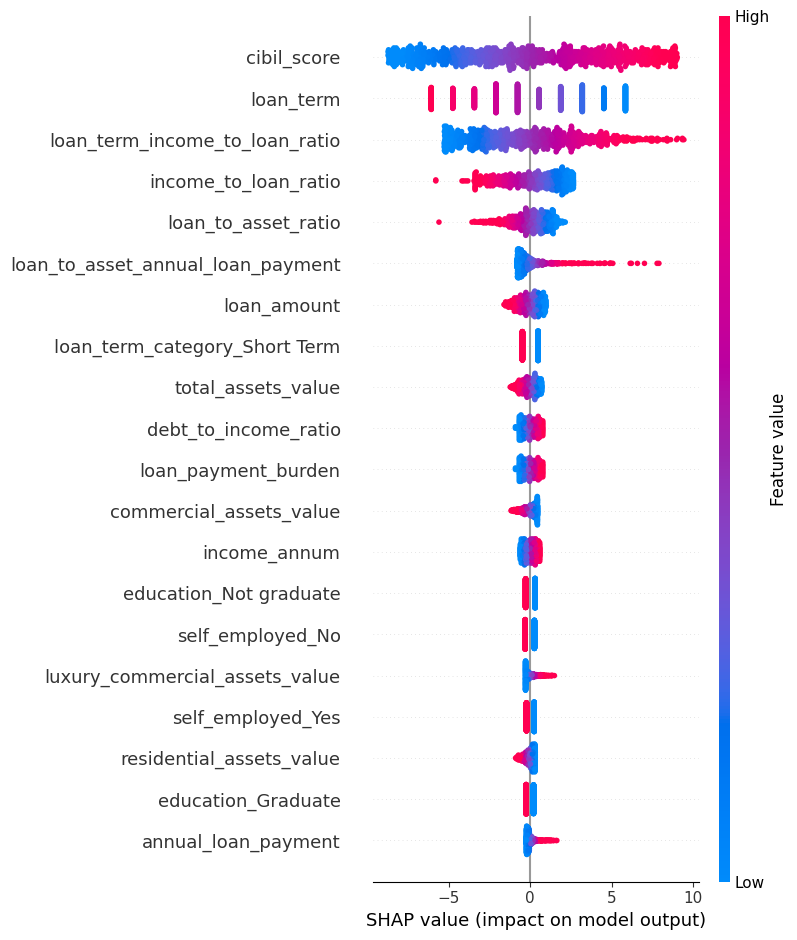

In [107]:
# Fit the logistic regression model on the selected features
logreg.fit(X_train_selected, y_train)

# Evaluate the model
y_pred = logreg.predict(X_test_selected)
print("Initial Model Report:\n", classification_report(y_test, y_pred))

# Hyperparameter tuning
param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'solver': ['liblinear', 'lbfgs', 'newton-cg', 'sag', 'saga'],
    'penalty': ['l2', 'none'],
    'max_iter': [100, 200, 300]
}
grid_search = GridSearchCV(logreg, param_grid, cv=5, scoring='f1_macro')
grid_search.fit(X_train_selected, y_train)

print(f"Best parameters: {grid_search.best_params_}")
best_model = grid_search.best_estimator_

cv_scores_best = cross_val_score(best_model, X_train_selected, y_train, cv=5, scoring='f1_macro')
print(f"Best model cross-validation scores: {cv_scores_best}")
print(f"Best model mean cross-validation score: {np.mean(cv_scores_best)}")

y_pred_best = best_model.predict(X_test_selected)
print("Improved Model Report:\n", classification_report(y_test, y_pred_best))

# SHAP analysis
explainer = shap.Explainer(best_model, X_train_selected)
shap_values = explainer(X_test_selected)

# Get feature names after one-hot encoding
ohe = preprocessor.named_transformers_['cat']['onehot']
ohe_feature_names = ohe.get_feature_names_out(cats)
all_feature_names = np.concatenate([nums, ohe_feature_names])

# Map selected indices to the original feature names
selected_feature_names = all_feature_names[selected_features_indices]

shap.summary_plot(shap_values, X_test_selected, feature_names=selected_feature_names)


# 5. Model Saving

In [115]:
# Create the final pipeline with the selected features
final_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('feature_selection', rfe),
    ('classifier', best_model)
])
# Save the pipeline model
with open('loan_approval_model.pkl', 'wb') as file:
    pickle.dump(final_pipeline, file)

In [114]:
final_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   MinMaxScaler())]),
                                                  ['no_of_dependents',
                                                   'income_annum',
                                                   'loan_amount', 'loan_term',
                                                   'cibil_score',
                                                   'residential_assets_value',
                                                   'commercial_assets_value',
                                                   'luxury_assets_value',
                                                   'bank_asset_value',
                                                   'income_to_loan_ratio',
                                                   'total_assets_value',
                                                   'loan_to_asset_ratio',...
                                                  Pipeline(steps=[('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['education', 'self_employed',
                                                   'loan_term_category',
                                                   'employment_education_interaction'])])),
                ('feature_selection',
                 RFE(estimator=LogisticRegression(random_state=42,
                                                  solver='liblinear'),
                     n_features_to_select=26)),
                ('classifier',
                 LogisticRegression(C=0.01, penalty='none', random_state=42,
                                    solver='saga'))])

In [164]:

sample_data = pd.DataFrame({
    'no_of_dependents': [2],
    'education': ['Graduate'],
    'self_employed': ['No'],
    'income_annum': [50000],
    'loan_amount': [20000],
    'loan_term': [360],
    'cibil_score': [900],
    'residential_assets_value': [150000],
    'commercial_assets_value': [50000],
    'luxury_assets_value': [20000],
    'bank_asset_value': [30000],
    'income_to_loan_ratio': [2.5],
    'total_assets_value': [250000],
    'loan_to_asset_ratio': [0.08],
    'dependents_to_income_ratio': [0.04],
    'loan_term_category': ["Short Term"],
    'employment_education_interaction': ["Yes_Not graduate"],
    'asset_to_income_ratio': [5],
    'annual_loan_payment': [12000],
    'debt_to_income_ratio': [0.24],
    'average_asset_value': [50000],
    'loan_payment_burden': [0.2],
    'asset_income_interaction': [10000],
    'loan_term_income_to_loan_ratio': [0.003],
    'loan_to_asset_annual_loan_payment': [0.01],
    'luxury_commercial_assets_value': [70000]
})

In [170]:
sample_data = loan_data[loan_data["loan_status"] == 1].head(1).drop(columns=['loan_status'])

In [182]:
import json
df_json = sample_data.to_json(orient='records')
parsed_json = json.loads(df_json)
print(json.dumps(parsed_json, indent=4))

[
    {
        "no_of_dependents": 2,
        "education": "Graduate",
        "self_employed": "No",
        "income_annum": 9600000,
        "loan_amount": 29900000,
        "loan_term": 12,
        "cibil_score": 778,
        "residential_assets_value": 2400000,
        "commercial_assets_value": 17600000,
        "luxury_assets_value": 22700000,
        "bank_asset_value": 8000000.0,
        "income_to_loan_ratio": 0.3210702341,
        "total_assets_value": 50700000.0,
        "loan_to_asset_ratio": 0.5897435897,
        "dependents_to_income_ratio": 2.083e-07,
        "loan_term_category": "Medium Term",
        "employment_education_interaction": "No_Graduate",
        "asset_to_income_ratio": 5.28125,
        "annual_loan_payment": 2491666.6666666665,
        "debt_to_income_ratio": 3.1145833333,
        "average_asset_value": 12675000.0,
        "loan_payment_burden": 3.1145833333,
        "asset_income_interaction": 486720000000000.0,
        "loan_term_income_to_loan_ratio"

In [183]:

prediction = model_pipeline.predict(sample_data)
print(f"predict: {prediction}")

predict: [1]
